In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from utils.database import *
import utils.hand as hand


/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
batch_size = 128

mr = ModelReader(batch_size)

Connecting to the PostgreSQL database...


In [110]:
batch = mr.getGraspBatch()

one_grasp = batch[12]
params = config(section='data')

scale, grasp_rescale, model_path = mr.getModelInfo(one_grasp["scaled_model_id"])

from pyntcloud import PyntCloud
model_file_name = params['model_dir'] + model_path
m = PyntCloud.from_file(model_file_name)
pt_cld = m.get_sample("mesh_random", n=10000, rgb=False, normals=False).values
pt_cld *= grasp_rescale
pt_cld *= scale


<IPython.core.display.Javascript object>


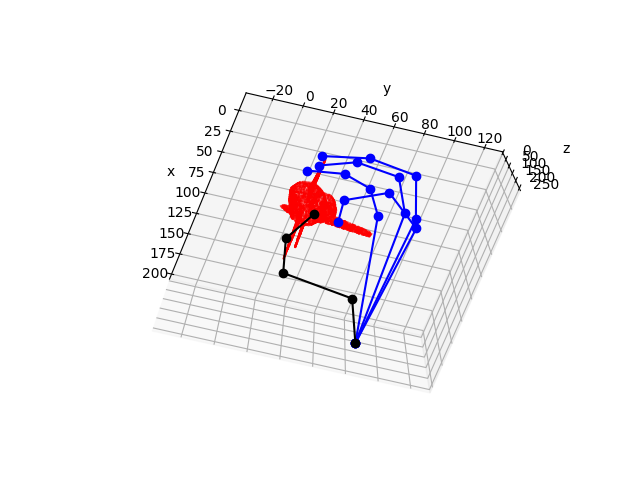

In [111]:
start = np.array(one_grasp['grasp_grasp_position'])[np.newaxis, 1:4].T
quat = np.array(one_grasp['grasp_grasp_position'])[4:8]

h = hand.makeHumanHand(start, quat)
hand_pts = h.getJointPositions()

h.updateDofs(np.array(one_grasp['grasp_grasp_joints'])[1:])
hand_pts = h.getJointPositions()
hand_pts = np.concatenate(hand_pts, axis=1).T

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(hand_pts[0, 0], hand_pts[0, 1], hand_pts[0, 2], zdir='z', c= 'red', s=10)
ax.scatter(pt_cld[:, 0], pt_cld[:, 1], pt_cld[:, 2], zdir='z', c= 'red', s=0.1)

# Axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax = ax.axis('equal')

# Draw hand
plt.plot(np.append(hand_pts[0, 0], hand_pts[1:5, 0]),   np.append(hand_pts[0, 1], hand_pts[1:5, 1]),   np.append(hand_pts[0, 2], hand_pts[1:5, 2]), '-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[5:9, 0]),   np.append(hand_pts[0, 1], hand_pts[5:9, 1]),   np.append(hand_pts[0, 2], hand_pts[5:9, 2]), '-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[9:13, 0]),  np.append(hand_pts[0, 1], hand_pts[9:13, 1]),  np.append(hand_pts[0, 2], hand_pts[9:13, 2]),'-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[13:17, 0]), np.append(hand_pts[0, 1], hand_pts[13:17, 1]), np.append(hand_pts[0, 2], hand_pts[13:17, 2]),'-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[17:21, 0]), np.append(hand_pts[0, 1], hand_pts[17:21, 1]), np.append(hand_pts[0, 2], hand_pts[17:21, 2]),'-o', c="black")

plt.show()

In [5]:
import os
import sys
def read_off(file):
        """
        Reads vertices and faces from an off file.
     
        :param file: path to file to read
        :type file: str
        :return: vertices and faces as lists of tuples
        :rtype: [(float)], [(int)]
        """
     
        assert os.path.exists(file)
     
        with open(file, 'r') as fp:
            lines = fp.readlines()
            lines = [line.strip() for line in lines]
     
            assert lines[0] == 'OFF'
     
            parts = lines[1].split(' ')
            assert len(parts) == 3
     
            num_vertices = int(parts[0])
            assert num_vertices > 0
     
            num_faces = int(parts[1])
            assert num_faces > 0
     
            vertices = []
            for i in range(num_vertices):
                vertex = lines[2 + i].split(' ')
                vertex = [float(point) for point in vertex]
                assert len(vertex) == 3
     
                vertices.append(vertex)
     
            faces = []
            for i in range(num_faces):
                face = lines[2 + num_vertices + i].split(' ')
                face = [int(index) for index in face]
     
                assert face[0] == len(face) - 1
                for index in face:
                    assert index >= 0 and index < num_vertices
     
                assert len(face) > 1
                faces.append(face)
     
            return vertices, faces

In [6]:
import numpy as np
import math

def AlignZ(v1,v2):  # Will align Z axis with X axis as 'UP' 
    dvec=v2-v1
    rotation_quat = dvec.to_track_quat('X', 'Z')
    return rotation_quat

In [7]:
def createCylinder():
    kCylinderGridSizeX = 32 # number of points in each direction
    kCylinderGridSizeY = 2  # number of points in each direction
    step_x = 1.0 / (kCylinderGridSizeX - 1)
    step_y = 1.0 / (kCylinderGridSizeY - 1)
    p = np.array([-0.5, 0.0, 0.0])       
    vertices = list()
    faces = list()
                 
    # Setup the vertices of the lattice.
    for i in range(kCylinderGridSizeY):
        p[0] = -0.5
        for j in range(kCylinderGridSizeX):
            vertices.append(np.array(p))
            p[0] += step_x
        p[1] += step_y

    # Compute the indices
    for n in range(kCylinderGridSizeX * kCylinderGridSizeY): 
        row = int(n / kCylinderGridSizeX)
        col = n % kCylinderGridSizeX

        if row > 0 and col > 0:
            faces.append([n, (row - 1) * kCylinderGridSizeX + col, (row - 1) * kCylinderGridSizeX + col - 1])
            faces.append([ n - 1, n, (row - 1) * kCylinderGridSizeX + col - 1])     
    return vertices, faces

In [112]:
import open3d as o3
import utils.util as util
from open3d import JVisualizer
import mathutils

print(model_file_name)

pcd = o3.PointCloud()
pcd.points = o3.Vector3dVector(pt_cld)


verts, faces = read_off(model_file_name)
meshes = list()

# Draw Model
m = o3.TriangleMesh()
m.vertices = o3.Vector3dVector(np.asarray(verts) * grasp_rescale * scale)
m.triangles = o3.Vector3iVector(np.asarray(faces)[:,1:])
m.compute_vertex_normals()
m.paint_uniform_color([1, 0.706, 0])


lines = [[0,1],[1,2],[2,3],[3,4],
         [0,5],[5,6],[6,7],[7,8],
         [0,9],[9,10],[10,11],[11,12],
         [0,13],[13,14],[14,15],[15,16],
         [0,17],[17,18],[18,19],[19,20]]

v, f = createCylinder()

# Draw bone cylinders
for line in lines:
    p0 = hand_pts[line[0]]
    p1 = hand_pts[line[1]]
    diff = p1 - p0
    bone_len = np.linalg.norm(p1-p0)
    
    p0 = mathutils.Vector(p0)
    p1 = mathutils.Vector(p1)
    q = AlignZ(p0,p1)
    mat = util.quat_to_rot(np.array([q.w, q.x, q.y, q.z]))
    
    verts = np.asarray(v)
    newverts = list()
    radius = 2.0
    for vertex in verts:
        newv = (mat@np.array([bone_len*vertex[1], radius*math.sin(2.0*np.pi*vertex[0]), radius*math.cos(2.0*np.pi*vertex[0])]).T).T
        newv += p0
        newverts.append(np.asarray(newv))
    
    cylinder = o3.TriangleMesh()
    cylinder.vertices = o3.Vector3dVector(newverts)
    cylinder.triangles= o3.Vector3iVector(np.asarray(f))
    cylinder.compute_vertex_normals()
    cylinder.paint_uniform_color([0, 0.406, 0.8])
    meshes.append(cylinder)

# Draw Joints
for point in hand_pts:
    mesh_sphere = o3.create_mesh_sphere(radius = 3.5)
    mesh_sphere.compute_vertex_normals()
    mesh_sphere.paint_uniform_color([0.1, 0.5, 1.])
    mesh_sphere.vertices = o3.Vector3dVector(np.asarray(mesh_sphere.vertices) + point)
    meshes.append(mesh_sphere)

meshes.append(m)
o3.draw_geometries(meshes)



/datasets//psb/benchmark/db/11/m1185/m1185.off
